<a href="https://colab.research.google.com/github/sudhakarmlal/EVA/blob/master/Assignment9/Assignment_9A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

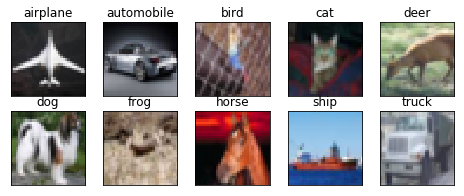

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
#plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255




In [0]:
test_features = test_features.astype('float32')/255

In [0]:
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
# summarize dataset shape
print('Train', train_features.shape, train_labels.shape)
print('Test', (test_features.shape, test_labels.shape))
# summarize pixel values
print('Train', train_features.min(), train_features.max(), train_features.mean(), train_features.std())
print('Test', test_features.min(), test_features.max(), test_features.mean(), test_features.std())

Train (50000, 32, 32, 3) (50000, 10)
Test ((10000, 32, 32, 3), (10000, 10))
Train 0.0 1.0 0.4733649 0.25156906
Test 0.0 1.0 0.47658524 0.25121963


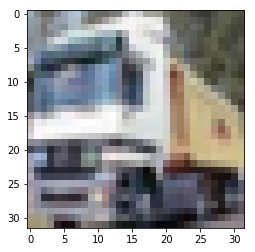

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(train_features[1])

#### Performing Image Normalization

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,data_format="channels_last")
# calculate mean on training dataset
datagen.fit(train_features)
# prepare an iterators to scale images
train_iterator = datagen.flow(train_features, train_labels, batch_size=128)
test_iterator = datagen.flow(test_features, test_features, batch_size=128)
print('Batches train=%d, test=%d' % (len(train_iterator), len(test_iterator)))
# confirm the scaling works
batchX, batchy = train_iterator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batches train=391, test=79
Batch shape=(128, 32, 32, 3), min=-1.989, max=2.127


In [0]:
from keras.callbacks import ModelCheckpoint

In [0]:
#Naming conventions to name convolution, batch normalization,maxpooling layers in the model
conv_name_base = 'convlayer_'
bn_name_base = 'bnlayer_'
mp_name_base = 'maxpooling_'

In [0]:
model2 = Sequential()
model2.add(Convolution2D(filters=32,kernel_size=(3,3),strides=1,padding='same',data_format='channels_last',input_shape=(32,32,3),use_bias=False,name = conv_name_base + '1')) #(3*3,32*32) of the form (effective global receptive field,output channel size )
model2.add(BatchNormalization(axis=3,name = bn_name_base + '1'))
model2.add(Activation('relu'))
model2.add(Dropout(0.1))

model2.add(Convolution2D(filters=64,kernel_size=(3,3),strides=1,padding='same',use_bias=False,name = conv_name_base + '2')) #(5*5,32*32)
model2.add(BatchNormalization(axis=3,name = bn_name_base + '2'))
model2.add(Activation('relu'))
model2.add(Dropout(0.1))

model2.add(Convolution2D(32,1,1,name = conv_name_base + '3')) #(5*5,32*32)
model2.add(BatchNormalization(axis=3,name = bn_name_base + '3'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2,2),name = mp_name_base +  '1')) #(10*10,16*16)
model2.add(Dropout(0.1))


model2.add(Convolution2D(filters=64,kernel_size=(3,3),strides=1,padding='same',use_bias=False,name = conv_name_base + '4')) #(12*12,16*16)
model2.add(BatchNormalization(axis=3,name = bn_name_base + '4'))
model2.add(Activation('relu'))
model2.add(Dropout(0.1))

model2.add(Convolution2D(filters=128,kernel_size=(3,3),strides=1,padding='same',use_bias=False,name = conv_name_base + '5')) #(14*14,16*16)
model2.add(BatchNormalization(axis=3,name = bn_name_base + '5'))
model2.add(Activation('relu'))
model2.add(Dropout(0.1))


model2.add(Convolution2D(32,1,1,name = conv_name_base + '6')) #(14*14,16*16)
model2.add(BatchNormalization(axis=3,name = bn_name_base + '6'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2,2),name = mp_name_base +  '2')) #(28*28,8*8)
model2.add(Dropout(0.1))


model2.add(Convolution2D(filters=32,kernel_size=(3,3),strides=1,padding='same',use_bias=False,name = conv_name_base + '7')) #(30*30,8*8)
model2.add(BatchNormalization(axis=3,name = bn_name_base + '7'))
model2.add(Activation('relu'))
model2.add(Dropout(0.1))


model2.add(Convolution2D(filters=64,kernel_size=(3,3),strides=1,padding='same',use_bias=False,name = conv_name_base + '8')) #(32*32,8*8)
model2.add(BatchNormalization(axis=3,name = bn_name_base + '8'))
model2.add(Activation('relu'))
model2.add(Dropout(0.1))



model2.add(Convolution2D(filters=10,kernel_size=(1,1),strides=1,padding='same',use_bias=False,name = conv_name_base + '9')) #(32*32,8*8)
model2.add(BatchNormalization(axis=3,name = bn_name_base + '9'))
model2.add(Activation('relu'))
model2.add(Dropout(0.1))


        
model2.add(Convolution2D(num_classes,8,8,name = conv_name_base + '10')) #(40*40,10*1*1)
#passing the final activations through softmax layer.
model2.add(Flatten())
model2.add(Activation('softmax'))

W0701 05:50:07.030898 140450234660736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0701 05:50:07.045589 140450234660736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0701 05:50:07.050173 140450234660736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0701 05:50:07.071386 140450234660736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0701 05:50:07.073463 1404502346

In [0]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convlayer_1 (Conv2D)         (None, 32, 32, 32)        864       
_________________________________________________________________
bnlayer_1 (BatchNormalizatio (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
convlayer_2 (Conv2D)         (None, 32, 32, 64)        18432     
_________________________________________________________________
bnlayer_2 (BatchNormalizatio (None, 32, 32, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
__________

In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

model2.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['accuracy'])

W0630 05:09:17.693203 139740959127424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
# checkpoint
filepath="./Assignment9_27_06_2019_evng-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,LearningRateScheduler(scheduler, verbose=1)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=70)`
  # This is added back by InteractiveShellApp.init_path()
W0627 11:04:38.133787 139700338104192 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_di

Epoch 1/70


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '



Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 20s 51ms/step - loss: 1.4514 - acc: 0.4689 - val_loss: 1.4289 - val_acc: 0.5081

Epoch 00001: val_acc improved from -inf to 0.50810, saving model to ./Assignment9_27_06_2019_evng-01-0.51.hdf5
Epoch 2/70

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
390/390 [==============================] - 15s 39ms/step - loss: 1.0304 - acc: 0.6296 - val_loss: 1.1827 - val_acc: 0.5739

Epoch 00002: val_acc improved from 0.50810 to 0.57390, saving model to ./Assignment9_27_06_2019_evng-02-0.57.hdf5
Epoch 3/70

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
390/390 [==============================] - 15s 38ms/step - loss: 0.8739 - acc: 0.6894 - val_loss: 1.1351 - val_acc: 0.6185

Epoch 00003: val_acc improved from 0.57390 to 0.61850, saving model to ./Assignment9_27_06_2019_evng-03-0.62.hdf5
Epoch 4/70

Epoch 00004: LearningRateScheduler se

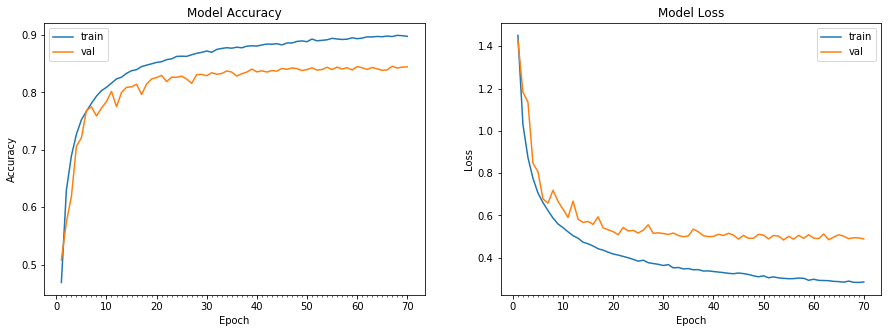

Accuracy on test data is: 84.45


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,data_format='channels_last')


# train the model
start = time.time()
# Train the model
model_info = model2.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 70, 
                                 validation_data = (test_features, test_labels), verbose=1,callbacks = callbacks_list )
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model2))

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

     |████████████████████████████████| 993kB 3.4MB/s 


In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
#root_dir = "/content/gdrive/My Drive/"
#base_dir = root_dir + 'EVA_assignment_9/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls "/content/gdrive"

'My Drive'


In [0]:
# Saving the best model from Google colab to Google drive
!cp  "./Assignment9_27_06_2019_evng-67-0.85.hdf5"  "/content/gdrive/My Drive/Assignment9_27_06_2019_evng-67-0.85.hdf5" 

In [0]:
# Saving the best model from Google drive  to Google colab
!cp  "/content/gdrive/My Drive/Assignment9_27_06_2019_evng-67-0.85.hdf5" "./Assignment9_27_06_2019_evng-67-0.85.hdf5" 

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,data_format="channels_last")
# calculate mean on training dataset
datagen.fit(train_features)
# prepare an iterators to scale images
train_iterator = datagen.flow(train_features, train_labels, batch_size=128)
test_iterator = datagen.flow(test_features, test_features, batch_size=128)
print('Batches train=%d, test=%d' % (len(train_iterator), len(test_iterator)))
# confirm the scaling works
batchX, batchy = train_iterator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batches train=391, test=79
Batch shape=(128, 32, 32, 3), min=-1.989, max=2.127


In [0]:
#Cifar stats mean and standard deviation along the RGB channels
cifar_stats = ([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])

In [0]:
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,data_format='channels_last')

In [0]:
model2.load_weights("Assignment9_27_06_2019_evng-67-0.85.hdf5")

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,data_format='channels_last')

In [0]:
datagen.fit(train_features)

In [0]:
datagen.mean

array([[[125.3069 , 122.95015, 113.866  ]]], dtype=float32)

In [0]:
datagen.std

array([[[62.993256, 62.08861 , 66.705   ]]], dtype=float32)

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys

In [0]:
def Gradcom_image(input_img,datagen,model):
  image_array = image.img_to_array(input_img)
  image_array = np.expand_dims(image_array, axis=0)
  
  image_array = datagen.standardize(image_array) #standarizing the image with RGB channel mean and standard deviation
  #image_array = preprocess_input(image_array)
  
  preds = model.predict(image_array)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("convlayer_8") # getting activation channels of the convolution layer before prediction layer
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([image_array])
  for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  #print(heatmap.shape)
  heatmap = cv2.resize(heatmap, (input_img.shape[1], input_img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  #print(heatmap.shape)
  #print(input_img.shape)
  #print(input_img.dtype)
  #print(heatmap.dtype)
  
  superimposed_img = cv2.addWeighted(input_img, 0.6, heatmap, 0.4, 0)
  
  return superimposed_img
  
    
  
  
  
  
  
  

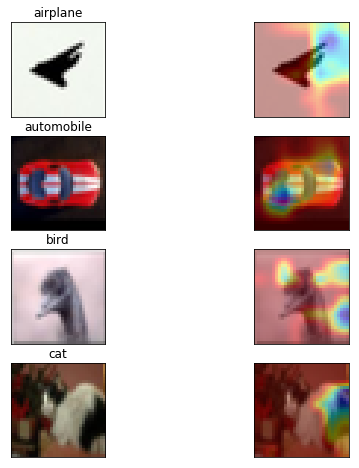

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
selected_classes_count = 4
fig = plt.figure(figsize=(8,8))
no_cols = 1
for each_class in range(selected_classes_count):
    ax = fig.add_subplot(selected_classes_count, 2, no_cols, xticks=[], yticks=[])
    no_cols = no_cols + 1
    idx = np.where(test_labels[:]== each_class)[0]
    features_idx = test_features[idx,::]
    #img_num = np.random.randint(len(idx))
    img_num = no_cols #Removing randomness and fixing the images
    im = features_idx[img_num]
    #ax.set_title(class_names[each_class])
    plt.imshow(im)
    #print("raw_image_shape")
    #print(im.shape)
    ax.set_title(class_names[each_class])
    ax1 = fig.add_subplot(selected_classes_count, 2, no_cols, xticks=[], yticks=[])
    no_cols = no_cols + 1
    img2 = Gradcom_image(im,datagen,model2)
    plt.imshow(img2)
    
plt.show()    